# 任务一 CNN手绘图像分类

## 1.1 读入图像并展示
1. 每类展示10个样本图像
2. 将‘ambulance’,‘apple’,‘bear’,‘bicycle’,‘bird’,‘bus’,‘cat’ 7个类的数据，每类按照7:2:1划分为“训练集”、“验证集”和“分布内测试集（IN-test）”
3. 将‘foot’,‘owl’,‘pig‘作为“分布外数据集”，每类抽取100张图像构成“分布外测试数据集（OOD-test）

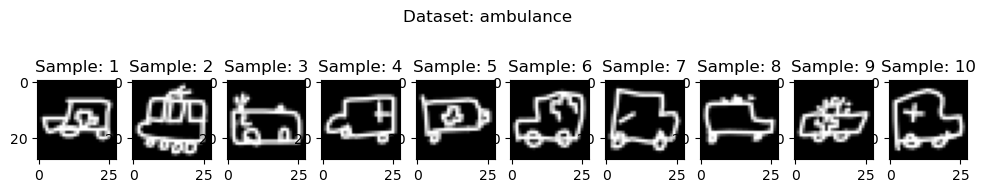

In [11]:
import numpy as np
import matplotlib.pyplot as plt


def read_and_show_data(path, dataset_name, show_num):
    file = np.load(path + '/' + dataset_name + '/' + dataset_name + '.npy')

    # 从数组中随机抽取3个元素的索引
    random_indices = np.random.choice(len(file), show_num, replace=False)
    # 根据索引获取相应的元素
    random_samples = file[random_indices]  

    # 绘图
    plt.figure(figsize=(12, 4))
    for i in range(show_num):
        plt.subplot(2, 10, i + 1) 

        image = random_samples[i].reshape(28, 28)

        plt.imshow(image, cmap='gray')
        plt.title(f"Sample: {i+1}")

    plt.suptitle(f"Dataset: {dataset_name}")
    plt.show()

    return file
read_and_show_data('./2023-GAI-实验4-图像数据集', 'ambulance', 10)